In [3]:
import math
import numpy as np
import random
from numpy import linalg as LA
import matplotlib.pyplot as plt

### PCA

In [8]:
pca_file = 'pca-data.txt'
pca_array = np.loadtxt(pca_file, delimiter='\t')

In [42]:
class PCA:
    def __init__(self, array):
        self.array = array
        self.dimension = array.shape[1]

    def covariance_matrix(self):
        num = np.zeros([self.dimension,self.dimension])
        for i in range(len(self.array)):
            xi = pca_array[i,:].reshape(self.dimension,1)
            num += np.dot(xi, xi.T)
        return num/len(self.array)

    def compute_eigen(self):
        cov = self.covariance_matrix()
        value, vector = LA.eig(cov)
        value = value.reshape(1,self.dimension)
        temp = np.vstack((value, vector))
        temp = temp.T[np.lexsort(-temp[::-1,:])].T #sort by first row, eigenvalues
        return temp[1:,:]
    
    def dimension_reduction(self, k):
        U = self.compute_eigen()
        Utr = U[:,:k]
        return np.dot(self.array, Utr)

In [43]:
PCA_model = PCA(pca_array)

In [44]:
PCA_model.dimension_reduction(2)

array([[ 10.9534134 ,   7.41334173],
       [-12.60979298,  -4.20854555],
       [  0.50903371,   0.306791  ],
       ...,
       [ -2.84597812,   2.45905342],
       [ 11.25979998,   4.24287306],
       [ 14.3065786 ,   5.68334496]])

In [45]:
PCA_model.compute_eigen()[:,:2]

array([[ 0.8666528 , -0.49630987],
       [-0.23278176, -0.49246586],
       [ 0.44127722,  0.71495027]])

### Fast Map

In [304]:
fastmap_file = 'fastmap-data.txt'
fastmap_array = np.loadtxt(fastmap_file, delimiter='\t')

In [318]:
wordlist_file = 'fastmap-wordlist.txt'
wordlist = []
with open(wordlist_file) as f:
    for i in f:
        i = i.strip('\n')
        wordlist.append(i)

In [265]:
class Fast_Map:
    def __init__(self, array, k):
        self.array = array
        self.dimension = array.shape[1]
        self.k = k  #target dimension
        self.Distance = {}
        self.points = set()
        for row in array:
            self.Distance[(row[0], row[1])] = row[2]
            self.points.add(row[0])
            self.points.add(row[1])
        self.result = np.zeros([len(self.points),k])
        
    def D(self, object1, object2, iteration_times):
        if object1 < object2:
            dis = self.Distance[(object1, object2)]
        elif object1 == object2:
            return 0
        else:
            dis = self.Distance[(object2, object1)]
        if iteration_times == 0:
            return dis
        else:
            for i in range(iteration_times):
                dis = (dis**2 - (self.result[int(object1)-1,i]-self.result[int(object2)-1,i])**2)**0.5
            return dis
    
    def farthest_pair(self, iteration_times):
        l = list(self.points)
        start_point, end_point = tuple(random.sample(l, 2))
        dis = self.D(start_point, end_point ,iteration_times)
        while True:
            old_end = end_point
            for point in l:
                if point != start_point:
                    temp_dis = self.D(start_point, point, iteration_times)
                    if temp_dis > dis:
                        dis = temp_dis
                        end_point = point
            if end_point == old_end:
                break
            temp_point = start_point
            start_point = end_point
            end_point = temp_point
        return start_point, end_point
    
    def projection(self):
        l = list(self.points)
        for iter_times in range(self.k):
            Oa, Ob = self.farthest_pair(iter_times)
            for i in range(len(l)):
                self.result[i,iter_times] = (self.D(Oa, l[i], iter_times)**2 + self.D(Oa, Ob, iter_times)**2 \
                                             - self.D(l[i], Ob, iter_times)**2)/(2 * self.D(Oa, Ob, iter_times))
        return self.result

In [266]:
Fast_Map_Model = Fast_Map(fastmap_array, 2)

In [287]:
projection = Fast_Map_Model.projection()

In [288]:
projection

array([[ 3.875     ,  1.9375    ],
       [ 3.        ,  0.25      ],
       [ 0.        ,  4.        ],
       [ 1.04166667,  6.8125    ],
       [ 2.45833333,  8.        ],
       [ 9.5       ,  2.8125    ],
       [ 2.45833333,  0.        ],
       [ 1.5       ,  6.4375    ],
       [ 2.45833333,  7.        ],
       [12.        ,  4.        ]])

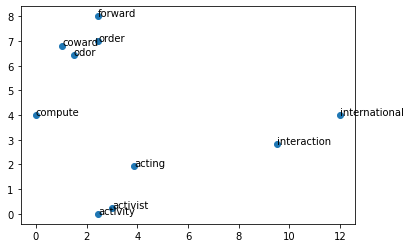

In [324]:
plt.scatter(projection[:,0], projection[:,1])
for i in range(len(wordlist)):
    plt.annotate(wordlist[i], xy=projection[i, :])